In [122]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import scipy.stats as stats

In [18]:
# load the dataset
adata = sc.datasets.pbmc3k()

Single-cell specific preprocessing from: https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

In [22]:
adata.var_names_make_unique()
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# QC
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

sc.pp.normalize_total(adata, target_sum=1e6) # normalize to counts-per-million (CPM)
sc.pp.log1p(adata) # logarithmize

# filter for HVGs
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]


# transfer annotations of processed data
processed_data = sc.datasets.pbmc3k_processed()
adata.obs = processed_data.obs

/home/hratch/anaconda3/envs/bootcamp/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [46]:
expr = adata.to_df().T
cell_md = adata.obs

The expression matrix is a gene by cell matrix containing log-normalized UMI counts of single-cell RNAseq measurements

In [54]:
expr.head()

index,AAACATACAACCAC-1,AAACATTGAGCTAC-1,AAACATTGATCAGC-1,AAACCGTGCTTCCG-1,AAACCGTGTATGCG-1,AAACGCACTGGTAC-1,AAACGCTGACCAGT-1,AAACGCTGGTTCTT-1,AAACGCTGTAGCCA-1,AAACGCTGTTTCTG-1,...,TTTCAGTGTCACGA-1,TTTCAGTGTCTATC-1,TTTCAGTGTGCAGT-1,TTTCCAGAGGTGAG-1,TTTCGAACACCTGA-1,TTTCGAACTCTCAT-1,TTTCTACTGAGGCA-1,TTTCTACTTCCTCG-1,TTTGCATGAGAGGC-1,TTTGCATGCCTCAC-1
index,,,,,,,,,,,,,,,,,,,,,
AGRN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ATAD3C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RP1-140A9.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RP5-892K4.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PLCH2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The cell metadata contains quantitative and categorical information associated with each individual measured cell

In [52]:
cell_md.head()

,n_genes,percent_mito,n_counts,louvain
index,,,,
AAACATACAACCAC-1,781,0.030178,2419.0,CD4 T cells
AAACATTGAGCTAC-1,1352,0.037936,4903.0,B cells
AAACATTGATCAGC-1,1131,0.008897,3147.0,CD4 T cells
AAACCGTGCTTCCG-1,960,0.017431,2639.0,CD14+ Monocytes
AAACCGTGTATGCG-1,522,0.012245,980.0,NK cells


# Data Scaling

We will scale each feature so that expression is comparable across them. In this case, we will simply use z-scoring 

In [106]:
expr_scaled = stats.zscore(expr, axis = 1) # axis = 1 specifies that z-scoring is done for each gene across cells rather than vice-versa

Differences in gene distributions across all cells are less pronounced after scaling, ensuring that not just highly expressed genes are biasing results: 

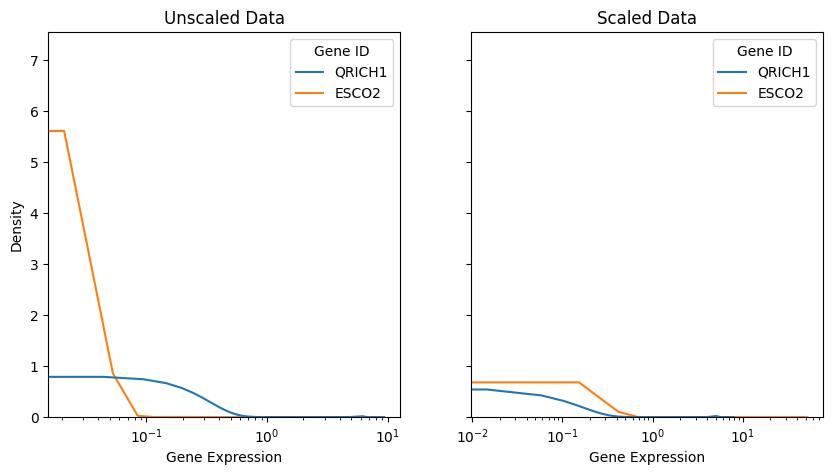

In [165]:
genes = ['QRICH1', 'ESCO2'] # genes with max and min means across all cells

fig, ax = plt.subplots(ncols = 2, figsize = (10,5), sharey = True)
sns.kdeplot(data = expr.loc[genes, :].T, ax = ax[0])
sns.kdeplot(data = expr_scaled.loc[genes, :].T, ax = ax[1])


ax[0].set_title('Unscaled Data')
ax[1].set_title('Scaled Data')
for i in range(2):
    ax[i].set_xscale('log')
    ax[i].set_xlabel('Gene Expression')
    ax[i].get_legend().set_title('Gene ID')

if want to discuss imputation, proceed here ---

A word on imputation: scRNA-seq data follows a negative binomial distribution. This means that matrices tend to be sparse:

# Linear Regression for QC

# Classification

# Dimensionality Reduction

In [53]:
expr_processed = expr.copy()

# Clustering